# Looking for data on Age and Ethnicity

In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from importlib import reload
from tqdm import tqdm_notebook as tqdm
from sklearn import linear_model as lm
import seaborn as sns
from fuzzywuzzy import fuzz
import time

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

params = {'xtick.labelsize':'x-large', 'ytick.labelsize':'x-large',
         'figure.figsize': (12,5), "axes.labelsize":'x-large'}
plt.rcParams.update(params)

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

282833 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['baseline_measurements',
                   'result_groups',
                   'eligibilities',
                   'outcomes',
                   'outcome_counts',
                   'outcome_measurements'])
ss.refresh_dim_data()

Successfuly added these 6 dimensions: ['baseline_measurements', 'result_groups', 'eligibilities', 'outcomes', 'outcome_counts', 'outcome_measurements']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 566 chunks x 500 records each

Creating index on the temp table
 - Loading dimension baseline_measurements
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index
 - Loading dimension eligibilities
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcomes
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_counts
 -- Loading raw data
 -- Sorting index
 - Loading dimension outcome_measurements
 -- Loading raw data
 -- Sorting index


In [5]:
# setting all the dimensional data to variables
bm = ss.dimensions['baseline_measurements'].data
rg = ss.dimensions['result_groups'].data
el = ss.dimensions['eligibilities'].data
out = ss.dimensions['outcomes'].data
oc = ss.dimensions['outcome_counts'].data
om = ss.dimensions['outcome_measurements'].data

In [6]:
# total number of studies
num_all = ss.studies.shape[0]
num_all

282833

In [7]:
# baseline measurement studies
bm_all = bm.index.get_level_values(0).unique().shape[0]
bm_all, bm_all / num_all

(43592, 0.15412628653657812)

### About 15% of the studies report Baseline Measurements

In [9]:
bm.columns

Index(['id', 'ctgov_group_code', 'classification', 'category', 'title',
       'description', 'units', 'param_type', 'param_value', 'param_value_num',
       'dispersion_type', 'dispersion_value', 'dispersion_value_num',
       'dispersion_lower_limit', 'dispersion_upper_limit',
       'explanation_of_na'],
      dtype='object')

# Steps 1-3 are investigative, step 4 starts implementation

# 1. Category column in BM

investingating the category column in the baseline measurements table

In [10]:
bmr = bm.reset_index()

In [11]:
all_cats = bmr.groupby('category')['nct_id'].count().sort_values(ascending=False)
all_cats

category
                                          558506
Female                                    123891
Male                                      123891
Unknown or Not Reported                    56790
>=65 years                                 40143
                                           ...  
Age ≥ 60 years                                 1
Age group at baseline: >18 years               1
Age group at baseline: >12 to 18 years         1
Age group at baseline: 6 to 12 years           1
Pancreatic islet cell tumors                   1
Name: nct_id, Length: 10341, dtype: int64

In [12]:
# seaching for specific keywords that indicate race
# this list was determined by looking at the top categories by count
possible_keywords = ['white', 'asian', 'african', 'indian', 
                     'native', 'islander', 'latino', 'hispanic']


# finding all category labels such that it matches above keywords
used_cats = []
for cur_cat in all_cats.index:
    for kw in possible_keywords:
        if kw in cur_cat.lower():
            if cur_cat not in used_cats:
                used_cats.append(cur_cat)
            next

In [13]:
# found this many categories that match race with atleast 1000 studies:
matched_cat_counts = all_cats.loc[used_cats]
used_cat_counts = matched_cat_counts[matched_cat_counts >= 1000]
len(used_cat_counts)

7

In [14]:
# let's eye ball through the list
used_cat_counts

category
White                                        35451
Asian                                        34834
Black or African American                    34091
American Indian or Alaska Native             33170
Native Hawaiian or Other Pacific Islander    32815
Hispanic or Latino                           25398
Not Hispanic or Latino                       25224
Name: nct_id, dtype: int64

In [15]:
used_cats = list(used_cat_counts.index)
used_cats

['White',
 'Asian',
 'Black or African American',
 'American Indian or Alaska Native',
 'Native Hawaiian or Other Pacific Islander',
 'Hispanic or Latino',
 'Not Hispanic or Latino']

### What are the characteristics of the studies that have these used categories?

In [16]:
df_cat = bm[bm['category'].isin(used_cats)]

In [17]:
# what are the titles of studies with the short-listed categories
s_cat_by_count = df_cat.groupby('title')['id'].count().sort_values(ascending=False)
s_cat_by_count

title
Race (NIH/OMB)                                      160385
Ethnicity (NIH/OMB)                                  48996
Race/Ethnicity, Customized                           11202
Race                                                   209
Ethnicity                                              104
Race (NIH/OMB) (Influenza Season 2016-2017)             15
Race (NIH/OMB) (Influenza Season 2015-2016)             15
Race, Customized                                        14
Race/Ethnicity                                           9
Primary Race                                             9
Ethnicty                                                 6
Ethnicity (NIH/OMB) (Influenza Season 2016-2017)         6
Ethnicity (NIH/OMB) (Influenza Season 2015-2016)         6
Race (Asian vs Non-Asian) at Randomization               3
Maternal Race                                            3
Donor Race/Ethnicity                                     1
Name: id, dtype: int64

In [18]:
# can just use the top few to capture most of the data
used_cat_titles = s_cat_by_count.index[:4]
used_cat_titles


Index(['Race (NIH/OMB)', 'Ethnicity (NIH/OMB)', 'Race/Ethnicity, Customized',
       'Race'],
      dtype='object', name='title')

### if we filter the original data by these titles, do we get back the original categories?

In [19]:
df_by_titles = bm[bm['title'].isin(used_cat_titles)]
df_by_titles.head()

id ctgov_group_code    classification  \
nct_id      result_group_id                                                
NCT00000125 18405171         20943952               B3             Other   
            18405171         20943955               B3             White   
            18405171         20943958               B3          Hispanic   
            18405171         20943961               B3  African American   
            18405171         20943964               B3             Asian   

                            category                       title description  \
nct_id      result_group_id                                                    
NCT00000125 18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00000125 18405171         participants     Number          14   
            18405171         participants     Number        1137   
            18405171         participants     Number          59   
            18405171         participants     Number         408   
            18405171         participants     Number          14   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00000125 18405171                    14.0                             None   
            18405171                  1137.0                             None   
            18405171                    59.0                             None   
            18405171                   408.0                             None   
            18405171                    14.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00000125 18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00000125 18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN

In [20]:
counts_by_title_cats = df_by_titles.groupby('category')['id'].count().sort_values(ascending=False)
counts_by_title_cats[counts_by_title_cats > 1000]

category
                                             80826
Unknown or Not Reported                      56672
White                                        35432
Asian                                        34816
Black or African American                    34074
American Indian or Alaska Native             33161
Native Hawaiian or Other Pacific Islander    32809
More than one race                           32160
Hispanic or Latino                           25333
Not Hispanic or Latino                       25167
Other                                         2568
Black                                         1062
Name: id, dtype: int64

### Looks like we do, except for a bunch of blank categories

### Q: Are the blanks for totals?

In [21]:
df_blank_cat = df_by_titles[df_by_titles['category'] == '']
df_blank_cat.groupby('classification')['id'].count().sort_values(ascending=False)[:10]

classification
White                                        9317
Asian                                        8797
Other                                        6703
Black or African American                    4813
Black                                        3708
Caucasian                                    2922
American Indian or Alaska Native             2850
Hispanic                                     2781
Hispanic or Latino                           2262
Native Hawaiian or Other Pacific Islander    1892
Name: id, dtype: int64

### A: Looks like those with blank category will have a classification reported with the ethnicity

so either the race is reported in the "category" field or the "classification" field

### "Category" Summary:
- scanning the category column for matched string ethnicities, we found a short list of titles that narrow down these ethnicities. 
    -- This is stored in the variable: used_cat_titles
- Filtering by these titles, we see that there is still many rows with blank categorys
- Found that these rows have the ethnicity tagged in the "classification" column

# 2. Classification column in BM

In [22]:
all_classes = bmr.groupby('classification')['nct_id'].count().sort_values(ascending=False)
all_classes

classification
                                           929902
United States                               49195
White                                        9468
Asian                                        8976
Other                                        8091
                                            ...  
Unemployed but seeking work                     1
First diagnosis                                 1
Black or American African                       1
PEP (n=89) - Black                              1
CYP2C19*17/CYP2C19*2 : Normal Phenotype         1
Name: nct_id, Length: 27048, dtype: int64

In [23]:
possible_keywords = ['white', 'asian', 'african', 'indian', 
                     'native', 'islander', 'latino', 'hispanic']


# finding all category labels such that it matches above keywords
used_classes = []
for cur_class in all_classes.index:
    for kw in possible_keywords:
        if kw in cur_class.lower():
            if cur_class not in used_classes:
                used_classes.append(cur_class)
            next

In [24]:
# found this many categories that match race with atleast 100 studies:
matched_class_counts = all_classes.loc[used_classes]
used_class_counts = matched_class_counts[matched_class_counts >= 100]
len(used_class_counts)

44

In [25]:
used_classes = list(used_class_counts.index)
used_classes

['White',
 'Asian',
 'Black or African American',
 'Caucasian',
 'Hispanic',
 'American Indian or Alaska Native',
 'Hispanic or Latino',
 'Native Hawaiian or Other Pacific Islander',
 'Not Hispanic or Latino',
 'African American',
 'African American/African Heritage',
 'Black/African American',
 'Native American',
 'Native Hawaiian or other Pacific Islander',
 'American Indian or Alaskan Native',
 'White - White/Caucasian/European Heritage',
 'Asian - East Asian Heritage',
 'Asian - South East Asian Heritage',
 'Hispanic/Latino',
 'White or Caucasian',
 'Asian - Japanese Heritage',
 'Asian - Central/South Asian Heritage',
 'African',
 'White - Arabic/North African Heritage',
 'White/Caucasian',
 'African-American',
 'East Asian',
 'Native Hawaiian or Pacific Islander',
 'Pacific Islander',
 'American Indian',
 'White Non-Hispanic',
 'American Indian/Alaska Native',
 'Asian/Pacific Islander',
 'American Indian/Alaskan Native',
 'Non-Hispanic White',
 'Caucasian/White',
 'Indian',
 'West

### What are the characteristics of the studies that have these used classifications?

In [26]:
df_class = bm[bm['classification'].isin(used_classes)]

In [27]:
s_class_by_count = df_class.groupby('title')['id'].count().sort_values(ascending=False)
s_class_by_count[:10]

title
Race/Ethnicity, Customized    46225
Race/Ethnicity                  800
Race (NIH/OMB)                  696
Race                            674
Ethnicity                       337
Ethnicity (NIH/OMB)             116
Predominant Race                 40
Race/Ethnicity, customized       40
Racial Group                     30
Race - U.S.A.                    21
Name: id, dtype: int64

### can just go with those with > 100 rows

In [28]:
# can just use the top few:
used_class_titles = s_class_by_count[s_class_by_count > 100].index
sorted(used_class_titles)

['Ethnicity',
 'Ethnicity (NIH/OMB)',
 'Race',
 'Race (NIH/OMB)',
 'Race/Ethnicity',
 'Race/Ethnicity, Customized']

In [29]:
sorted(used_cat_titles)

['Ethnicity (NIH/OMB)', 'Race', 'Race (NIH/OMB)', 'Race/Ethnicity, Customized']

### Looks like the class titles have extra vs cat titles:
- Ethnicity
- Race/Ethnicity

But is otherwise a superset

### if we filter by these titles, do we get back the original classifications?

In [30]:
df_by_titles = bm[bm['title'].isin(used_class_titles)]
df_by_titles.head()

id ctgov_group_code    classification  \
nct_id      result_group_id                                                
NCT00000125 18405171         20943952               B3             Other   
            18405171         20943955               B3             White   
            18405171         20943958               B3          Hispanic   
            18405171         20943961               B3  African American   
            18405171         20943964               B3             Asian   

                            category                       title description  \
nct_id      result_group_id                                                    
NCT00000125 18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               
            18405171                  Race/Ethnicity, Customized               

                                    units param_type param_value  \
nct_id      result_group_id                                        
NCT00000125 18405171         participants     Number          14   
            18405171         participants     Number        1137   
            18405171         participants     Number          59   
            18405171         participants     Number         408   
            18405171         participants     Number          14   

                             param_value_num dispersion_type dispersion_value  \
nct_id      result_group_id                                                     
NCT00000125 18405171                    14.0                             None   
            18405171                  1137.0                             None   
            18405171                    59.0                             None   
            18405171                   408.0                             None   
            18405171                    14.0                             None   

                             dispersion_value_num  dispersion_lower_limit  \
nct_id      result_group_id                                                 
NCT00000125 18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   
            18405171                          NaN                     NaN   

                             dispersion_upper_limit explanation_of_na  
nct_id      result_group_id                                            
NCT00000125 18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN                    
            18405171                            NaN

In [31]:
counts_by_title_cats = df_by_titles.groupby('classification')['id'].count().sort_values(ascending=False)
counts_by_title_cats[counts_by_title_cats > 1000]

classification
                                             310527
White                                          9383
Asian                                          8898
Other                                          6810
Race                                           4891
Black or African American                      4862
Black                                          3773
Caucasian                                      3097
Hispanic                                       2996
American Indian or Alaska Native               2864
Hispanic or Latino                             2384
Native Hawaiian or Other Pacific Islander      1913
Not Hispanic or Latino                         1460
Race/Ethnicity                                 1451
Ethnicity                                      1273
Unknown                                        1099
African American                               1045
Name: id, dtype: int64

### Q: What are the blanks for?

In [32]:
df_blank_cat = df_by_titles[df_by_titles['classification'] == '']
df_blank_cat.groupby('category')['id'].count().sort_values(ascending=False)[:10]

category
Unknown or Not Reported                      56041
White                                        33961
Asian                                        33610
Black or African American                    33188
American Indian or Alaska Native             32554
Native Hawaiian or Other Pacific Islander    32278
More than one race                           31785
Hispanic or Latino                           24807
Not Hispanic or Latino                       24731
Other                                         1466
Name: id, dtype: int64

### A: We have cross coverage between classification and category for the same race/ethn titles

# 3. Narrowing the studies by Title, Classification and Category

In [33]:
# combining the valid titles from both category and classification
all_used_titles = []
for cur_title in used_class_titles:
    if cur_title not in all_used_titles:
        all_used_titles.append(cur_title)
        
for cur_title in used_cat_titles:
    if cur_title not in all_used_titles:
        all_used_titles.append(cur_title)       

all_used_titles        

['Race/Ethnicity, Customized',
 'Race/Ethnicity',
 'Race (NIH/OMB)',
 'Race',
 'Ethnicity',
 'Ethnicity (NIH/OMB)']

### Let's Eyeball through some examples by title

In [34]:
for cur_title in all_used_titles:
    print("BM Title: %s" % cur_title)
    sub_df = bm[bm['title'] == cur_title]
    all_nct_id = sub_df.index.get_level_values(0).unique()
    print(np.random.choice(all_nct_id, 5))
    print("\n")

BM Title: Race/Ethnicity, Customized
['NCT00834613' 'NCT02249182' 'NCT02227706' 'NCT01332292' 'NCT00601965']


BM Title: Race/Ethnicity
['NCT00356525' 'NCT00190671' 'NCT02001194' 'NCT00146770' 'NCT00191724']


BM Title: Race (NIH/OMB)
['NCT02944383' 'NCT02570139' 'NCT02522481' 'NCT01099631' 'NCT03138655']


BM Title: Race
['NCT01576146' 'NCT02194933' 'NCT03633448' 'NCT03649750' 'NCT03649750']


BM Title: Ethnicity
['NCT01729871' 'NCT00794664' 'NCT01729871' 'NCT00633477' 'NCT00459316']


BM Title: Ethnicity (NIH/OMB)
['NCT02287584' 'NCT00924066' 'NCT00005803' 'NCT02732951' 'NCT02037295']




### Notes:
- Some studies report both race and ethnicity as different metrics: NCT01611194
- looks like "Race (NIH/OMB) is the one that we want if both Ethnicity (NIH/OMB) and that are reported
- also drop the 2 ethnicity titles

In [35]:
# this determines the set of data used for the final race data set
final_used_titles = [x for x in all_used_titles if 'race' in x.lower()]
final_used_titles

['Race/Ethnicity, Customized', 'Race/Ethnicity', 'Race (NIH/OMB)', 'Race']

In [36]:
bm_used = bm[bm['title'].isin(final_used_titles)]

In [37]:
num_used = len(bm_used.index.get_level_values(0).unique())
num_used

18378

In [38]:
# this % of studies is covered by the current set
num_used / bm_all

0.42159111763626356

#### turns out to be 41% of those that report baseline measurements

# 4. Merging the category and classification into 1 used study set

In [39]:
double_counts = bm_used.groupby(['classification', 'category'])['id'].count().sort_values(ascending=False)
double_counts[double_counts > 500]

classification                             category                                 
                                           White                                        33961
                                           Asian                                        33610
                                           Black or African American                    33188
                                           American Indian or Alaska Native             32554
                                           Native Hawaiian or Other Pacific Islander    32278
                                           Unknown or Not Reported                      31820
                                           More than one race                           31785
White                                                                                    9378
Asian                                                                                    8877
Other                                                                

### Plan: We look at category first, then in the remaining where category is blank, look at the classification

In [40]:
cat_counts = bm_used.groupby('category')['id'].count().sort_values(ascending=False)
cat_counts[cat_counts > 100]

category
                                             81791
White                                        35435
Asian                                        34819
Black or African American                    34077
American Indian or Alaska Native             33161
Native Hawaiian or Other Pacific Islander    32809
Unknown or Not Reported                      32191
More than one race                           32160
Other                                         2571
Black                                         1062
Hispanic or Latino                             844
Not Hispanic or Latino                         660
Hispanic                                       630
Caucasian                                      512
Unknown                                        439
Not Permitted                                  350
Missing                                        254
Multiple                                       249
African American                               248
American Indian or Ala

In [41]:
# eyeballing which ones are the N/A categories
cat_unknowns = ['Unknown or Not Reported', 
                'More than one race', 
                'Unknown', 
                'Not Permitted', 
                'Missing', 
                'Multiple', 
                'Not Reported']

In [42]:
# why do we get the "ethnicity" labels still? (ex: Hispanic or Latino)
eth_cats = ['Hispanic or Latino', 'Not Hispanic or Latino']

## 4 a) Case 1: Category is non-blank

In [43]:
bm_used_case1 = bm_used[bm_used['category'] != '']

# already checked that the "Count of Participants" is the dominate param type
bm_used_case1 = bm_used_case1[bm_used_case1['param_type'] == 'Count of Participants']

# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case1.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case1_nct_ids = bm_used_case1.index.get_level_values(0).unique()

Pct of bm rows: 75.4%


In [44]:
bm_full_case1 = bm_used.loc[case1_nct_ids]
bm_full_case1 = bm_full_case1[bm_full_case1['param_type'] == 'Count of Participants']
print("Pct of bm rows: %.1f%%" % (bm_full_case1.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 75.6%


In [45]:
bm_full_case1.groupby('param_type')['id'].count()

param_type
Count of Participants    251942
Name: id, dtype: int64

## Joining to result groups to get the group labels:

In [46]:
dfm_case1 = bm_full_case1.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [47]:
dfm_case1.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Usual Care', 'All Participants',
       'All Study Participants', 'Control Group', 'Intervention',
       'Standard of Care', 'Treatment', 'Overall Study', 'Cohort 1',
       'Cohort 2', 'Sugar Pill', 'Vehicle', 'Arm 1', 'Overall',
       'Treatment Arm', 'Placebo Group', 'Arm 2', 'Cohort 3', 'Group 1',
       'Group B', 'Group A', 'Group 2', 'Control Arm', 'Arm A', 'Arm B',
       'Arm I', 'Single Arm', 'Treatment as Usual', 'Arm II (Placebo)',
       'All Patients', 'Normal Saline', 'Entire Study Population',
       'Standard Care', 'Duloxetine', 'Pembrolizumab', 'Intervention Group',
       'Saline', 'Total Title', 'Varenicline', 'Active', 'Ketamine',
       'Cohort A', 'Metformin', 'Cohort B', 'All Subjects', 'Placebo Arm',
       'Dose Level 1'],
      dtype='object', name='title_rg')

### Need to get rid of the total rows

In [48]:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [49]:
dfm_case1_nontot = dfm_case1[~dfm_case1['title_rg'].isin(total_strings)].copy()
len(dfm_case1_nontot['nct_id'].unique())

12372

In [50]:
df_case1_totcounts = dfm_case1_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c1j = df_case1_totcounts.join(ss.studies[['enrollment']])
df_c1j['tot_per_enroll'] = df_c1j['param_value_num'] / df_c1j['enrollment']
df_c1j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00001262,60.0,60.0,1.0
NCT00001304,27.0,27.0,1.0
NCT00001305,42.0,42.0,1.0
NCT00001575,87.0,87.0,1.0
NCT00001586,105.0,105.0,1.0


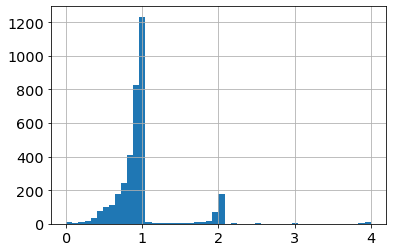

In [51]:
df_c1j[df_c1j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

### Some studies report multiple times for ethnicity - should not be double counted

### Idea: let's just keep those studies with totals that sum up to smaller or equal to total enrollment

In [52]:
non_double_counted = df_c1j[df_c1j['param_value_num'] <= df_c1j['enrollment']]
non_double_counted.shape[0] / df_c1j.shape[0]

0.9688813449725185

In [53]:
df_final_case1 = dfm_case1_nontot[dfm_case1_nontot['nct_id'].isin(non_double_counted.index)].copy()

In [54]:
# % of rows in bm_used
df_final_case1.shape[0] / bm_used.shape[0]

0.5435641068727944

In [55]:
# % of nct_ids in bm_used
len(df_final_case1['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.652247252149309

## 4 b) Case 2: Category is blank (look in the classification field)

In [56]:
bm_used_case2 = bm_used[bm_used['category'] == '']

# checked that these 2 are the dominate characterstics
bm_used_case2 = bm_used_case2[bm_used_case2['param_type'].isin(['Count of Participants', 'Number'])]


# % of the data ..
print("Pct of bm rows: %.1f%%" % (bm_used_case2.shape[0] / bm_used.shape[0] * 100))

# unique ids for this case
case2_nct_ids = bm_used_case2.index.get_level_values(0).unique()

Pct of bm rows: 24.5%


In [57]:
bm_full_case2 = bm_used.loc[case2_nct_ids]
bm_full_case2 = bm_full_case2[bm_full_case2['param_type'].isin(['Count of Participants', 'Number'])]
print("Pct of bm rows: %.1f%%" % (bm_full_case2.shape[0] / bm_used.shape[0] * 100))

Pct of bm rows: 25.0%


## Joining to result groups to get the group labels:

In [58]:
dfm_case2 = bm_full_case2.reset_index().merge(rg.reset_index()[['nct_id', 'ctgov_group_code', 'title']], 
                                              on=['nct_id', 'ctgov_group_code'], 
                                              how='inner', 
                                              suffixes=('', '_rg'))

In [59]:
dfm_case2.groupby('title_rg').size().sort_values(ascending=False)[:50].index

Index(['Total', 'Placebo', 'Control', 'Usual Care', 'Control Group',
       'All Participants', 'All Study Participants', 'Standard of Care',
       'Overall Study', 'Sitagliptin 100 mg', 'Duloxetine', 'Cinacalcet',
       'Treatment', 'Intervention', 'Cohort 2', 'Cohort 1', 'Overall',
       'Lixisenatide', 'Denosumab', 'Dispensed Subjects', 'Lapatinib',
       'Denosumab 60 mg Q6M', 'Placebo MDPI', 'Vehicle Foam', 'Placebo Group',
       'Vehicle', 'Iron Isomaltoside/Ferric Derisomaltose', 'Standard Care',
       'Sitagliptin', 'Fp MDPI 100 mcg', 'FF 100 µg OD',
       'Entire Study Population', 'Arm 1', 'SOF/VEL 12 Weeks', 'Placebo Q2W',
       'FF/VI 100/25 µg QD', 'Vortioxetine 10 mg', 'Escitalopram', 'Metformin',
       'Fasiglifam 50 mg', 'Trastuzumab', 'Placebo QD', 'FF/VI 100/25 µg OD',
       'Insulin Glargine', 'Stribild', 'VI 25 µg QD', 'Etanercept', 'Cohort 3',
       'Experimental', 'Infanrix Hexa Group'],
      dtype='object', name='title_rg')

In [60]:
# still the same total strings:
total_strings = ['Total', 
                 'All Participants', 
                 'All Study Participants', 
                 'Entire Study Population',
                 'Overall Study',
                 'Overall', 
                 'Total Title']

In [61]:
dfm_case2_nontot = dfm_case2[~dfm_case2['title_rg'].isin(total_strings)].copy()
len(dfm_case2_nontot['nct_id'].unique())

5602

In [62]:
df_case2_totcounts = dfm_case2_nontot.groupby('nct_id')[['param_value_num']].sum()
df_c2j = df_case2_totcounts.join(ss.studies[['enrollment']])
df_c2j['tot_per_enroll'] = df_c2j['param_value_num'] / df_c2j['enrollment']
df_c2j.head()

,param_value_num,enrollment,tot_per_enroll
nct_id,,,
NCT00000125,1636.0,1636.0,1.000000
NCT00000392,212.0,215.0,0.986047
NCT00000620,10251.0,10251.0,1.000000
NCT00001941,34.0,34.0,1.000000
NCT00002850,212.0,212.0,1.000000


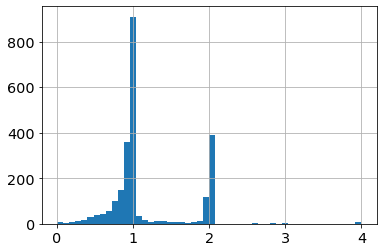

In [63]:
df_c2j[df_c2j['tot_per_enroll'] != 1.0]['tot_per_enroll'].clip(0, 4).hist(bins=50)

In [64]:
non_double_counted_case2 = df_c2j[df_c2j['param_value_num'] <= df_c2j['enrollment']]
non_double_counted_case2.shape[0] / df_c2j.shape[0]

0.8662977508032845

In [65]:
df_final_case2 = dfm_case2_nontot[dfm_case2_nontot['nct_id'].isin(non_double_counted_case2.index)].copy()

In [66]:
# % of rows in bm_used
df_final_case2.shape[0] / bm_used.shape[0]

0.14548575269462516

In [67]:
# % of nct_ids in bm_used
len(df_final_case2['nct_id'].unique()) / len(bm_used.index.get_level_values(0).unique())

0.26406573076504514

### Do we have any nct_ids in both cases?

In [68]:
c1_nct = df_final_case1['nct_id'].unique()
c2_nct = df_final_case2['nct_id'].unique()

In [69]:
[x for x in c1_nct if x in c2_nct]

['NCT01960075', 'NCT03237065']

only 2 cases, let's just take their case 1 datapoints

In [70]:
df_final_case1['used_race'] = df_final_case1['category']
df_final_case2['used_race'] = df_final_case2['classification']

df_final_case2_not_case1 = df_final_case2[~df_final_case2['nct_id'].isin(df_final_case1['nct_id'].unique())]

In [71]:
req_columns = [
    'nct_id', 
    'result_group_id',
    'title',
    'ctgov_group_code',
    'used_race',
    'param_value_num'
]

## 4 c) Joining together the cases

In [72]:
df_final_all = pd.concat([df_final_case1[req_columns], df_final_case2_not_case1[req_columns]])

In [73]:
df_final_all.shape[0] / bm_used.shape[0]

0.6889538372902514

In [74]:
# % of all nctids that report baseline measures
num_studies_report_race = len(df_final_all['nct_id'].unique())
num_studies_report_race / len(bm.index.get_level_values(0).unique()), num_studies_report_race

(0.3862635345935034, 16838)

In [75]:
dftotals = df_final_all.groupby('nct_id')[['param_value_num']].sum()

In [76]:
df_percentile_totals = dftotals.describe(np.arange(0,1,0.01))
df_percentile_totals.index.name='percentile'
df_percentile_totals.reset_index(inplace=True)
df_percentile_totals = df_percentile_totals[df_percentile_totals['percentile'].apply(lambda x: 
                                                                                     True if '%' in x 
                                                                                     else False)]
df_percentile_totals[15:25]

,percentile,param_value_num
19,15%,16.0
20,16%,18.0
21,17%,19.0
22,18%,20.0
23,19%,20.0
24,20%,21.0
25,21%,23.0
26,22%,24.0
27,23%,24.0
28,24%,25.0


### We picked to keep 80% of the data and exclude any studies such the total <= 20

In [77]:
df_totals_used = dftotals[dftotals['param_value_num'] > 20]
df_totals_used.shape

(13573, 1)

In [78]:
df_final_g20 = df_final_all[df_final_all['nct_id'].isin(df_totals_used.index.unique())]
df_final_g20.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num
7,NCT00001262,18404948,Race (NIH/OMB),B3,Unknown or Not Reported,0.0
8,NCT00001262,18404948,Race (NIH/OMB),B3,More than one race,0.0
9,NCT00001262,18404948,Race (NIH/OMB),B3,White,3.0
10,NCT00001262,18404948,Race (NIH/OMB),B3,Black or African American,0.0
11,NCT00001262,18404948,Race (NIH/OMB),B3,Native Hawaiian or Other Pacific Islander,0.0


### Only keep those with 2 Arms or more

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fafe7e3f588>]],
      dtype=object)

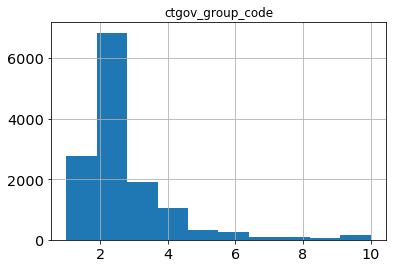

In [79]:
df_final_g20.groupby('nct_id')[['ctgov_group_code']].nunique().clip(0, 10).hist(bins=10)

In [80]:
# only keep studies with greater than 2 arms
s_ngrps = df_final_g20.groupby('nct_id')['ctgov_group_code'].nunique()
nct_id_more_than_2arm = s_ngrps[s_ngrps >= 2].index
len(nct_id_more_than_2arm)

10797

In [81]:
# % of studies with bm
# % of all studies in database
len(nct_id_more_than_2arm) / bm_all, len(nct_id_more_than_2arm) / num_all 

(0.24768306111213068, 0.038174470447225044)

In [82]:
df_more_than_two_arm = df_final_g20[df_final_g20['nct_id'].isin(nct_id_more_than_2arm)].reset_index(drop=True)
df_more_than_two_arm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num
0,NCT00001262,18404948,Race (NIH/OMB),B3,Unknown or Not Reported,0.0
1,NCT00001262,18404948,Race (NIH/OMB),B3,More than one race,0.0
2,NCT00001262,18404948,Race (NIH/OMB),B3,White,3.0
3,NCT00001262,18404948,Race (NIH/OMB),B3,Black or African American,0.0
4,NCT00001262,18404948,Race (NIH/OMB),B3,Native Hawaiian or Other Pacific Islander,0.0


df_more_than_two_arm contains all baseline measurements of studies that report race

# 5. Outcome measurements
- The report group means and stds has to be retreived from the other table

In [83]:
omj = om.reset_index().add_prefix('om_')
out_is_prim = out.set_index('id')['outcome_type']
omj['isprim'] = omj['om_outcome_id'].apply(lambda x: out_is_prim[x])

In [84]:
used_dispersion_types = ['Standard Deviation', 'Standard Error']

# filter outcome measurements by just those with mean and std measures
omj_used = omj[(omj['om_param_type'] == 'Mean') & 
               (omj['om_dispersion_type'].isin(used_dispersion_types)) &
               (omj['isprim'] == 'Primary')]

omj_used.shape

(184406, 20)

In [85]:
# studies from the baseline measurement race requirements above
studies_w_race_info = df_more_than_two_arm['nct_id'].unique()
len(studies_w_race_info)

10797

omj_used contains all outcome measurements that reports a mean and a standard error/deviation and is a primary outcome.

In [86]:
omj_used.head()

,om_nct_id,om_result_group_id,om_outcome_id,om_id,om_ctgov_group_code,om_classification,om_category,om_title,om_description,om_units,om_param_type,om_param_value,om_param_value_num,om_dispersion_type,om_dispersion_value,om_dispersion_value_num,om_dispersion_lower_limit,om_dispersion_upper_limit,om_explanation_of_na,isprim
22,NCT00000371,18405001,5589265,42918129,O2,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,Mean,-.41,-0.41,Standard Error,.31,0.31,NaN,NaN,,Primary
23,NCT00000371,18405002,5589265,42918130,O1,,,Scale for the Assessment of Negative Symptoms ...,The slope of SANS total score from baseline to...,units on a scale/weeks,Mean,-.46,-0.46,Standard Error,.29,0.29,NaN,NaN,,Primary
24,NCT00000378,18404992,5589264,42918125,O2,12 WEEK DATA,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,8.4,8.40,Standard Deviation,7.7,7.70,NaN,NaN,,Primary
25,NCT00000378,18404992,5589264,42918127,O2,BASELINE,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,27.1,27.10,Standard Deviation,4.4,4.40,NaN,NaN,,Primary
26,NCT00000378,18404993,5589264,42918126,O1,12 WEEK DATA,,HAMILTON Rating Scale for DEPRESSION Range,"Hamilton scale range 0-40, values below 7 are ...",units on a scale,Mean,10.7,10.70,Standard Deviation,8.3,8.30,NaN,NaN,,Primary


### found that when the number of groups in om vs bm are unequal, they don't necessarily line up

ex: NCT03816761

As a result filter results to those that have equal number of groups

In [87]:
omj_counts = omj_used.groupby('om_nct_id')[['om_ctgov_group_code']].nunique()
df_counts = df_more_than_two_arm.groupby('nct_id')[['ctgov_group_code']].nunique()
df_intersection = omj_counts.join(df_counts, how='inner')
df_intersection_used = df_intersection[df_intersection['om_ctgov_group_code'] ==
                                       df_intersection['ctgov_group_code']]

df_intersection.shape, df_intersection_used.shape

((3478, 2), (3122, 2))

## MANUAL STEP: Let's step through some examples with 3 arms or more

In [88]:
df_mta_intersect = df_more_than_two_arm[df_more_than_two_arm['nct_id'].isin(df_intersection_used.index)].copy()
num_nct_ids = df_mta_intersect.groupby('nct_id')['ctgov_group_code'].nunique()
intersect_morethan2groups = num_nct_ids[num_nct_ids > 2]
len(intersect_morethan2groups)

883

In [89]:
test_nct_id = np.random.choice(intersect_morethan2groups.index)
test_nct_id

'NCT03118765'

In [90]:
omj_used[omj_used['om_nct_id'] == test_nct_id].T

,2464851,2464852,2464853,2464854,2464855,2464856,2464857,2464858,2464859,2464860,2464861,2464862,2464863
om_nct_id,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765
om_result_group_id,17287705,17287706,17287707,17287708,17287709,17287710,17287711,17287712,17287713,17287714,17287715,17287716,17287717
om_outcome_id,5253515,5253515,5253515,5253515,5253515,5253516,5253516,5253516,5253516,5253517,5253517,5253517,5253517
om_id,40360683,40360684,40360685,40360686,40360687,40360688,40360689,40360690,40360691,40360692,40360693,40360694,40360695
om_ctgov_group_code,O5,O4,O3,O2,O1,O4,O3,O2,O1,O4,O3,O2,O1
om_classification,,,,,,,,,,,,,
om_category,,,,,,,,,,,,,
om_title,Change From Baseline (Day 1) in Trough FEV1 at...,Change From Baseline (Day 1) in Trough FEV1 at...,Change From Baseline (Day 1) in Trough FEV1 at...,Change From Baseline (Day 1) in Trough FEV1 at...,Change From Baseline (Day 1) in Trough FEV1 at...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...,Relative Bioavailability of Tiotropium With GS...
om_description,Change from baseline (Day 1) at Day 21 (Week 3...,Change from baseline (Day 1) at Day 21 (Week 3...,Change from baseline (Day 1) at Day 21 (Week 3...,Change from baseline (Day 1) at Day 21 (Week 3...,Change from baseline (Day 1) at Day 21 (Week 3...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...,The PK endpoint in plasma to assess the relati...
om_units,L,L,L,L,L,h*pg/mL,h*pg/mL,h*pg/mL,h*pg/mL,pg/mL,pg/mL,pg/mL,pg/mL


In [91]:
df_more_than_two_arm[df_more_than_two_arm['nct_id'] == test_nct_id].T

,123099,123100,123101,123102,123103,123104,123105,123106,123107,123108,...,123124,123125,123126,123127,123128,123129,123130,123131,123132,123133
nct_id,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,...,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765,NCT03118765
result_group_id,17287621,17287621,17287621,17287621,17287621,17287621,17287621,17287622,17287622,17287622,...,17287624,17287624,17287624,17287625,17287625,17287625,17287625,17287625,17287625,17287625
title,Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),...,Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB),Race (NIH/OMB)
ctgov_group_code,B5,B5,B5,B5,B5,B5,B5,B4,B4,B4,...,B2,B2,B2,B1,B1,B1,B1,B1,B1,B1
used_race,Black or African American,Native Hawaiian or Other Pacific Islander,Asian,American Indian or Alaska Native,Unknown or Not Reported,More than one race,White,Black or African American,Native Hawaiian or Other Pacific Islander,Asian,...,American Indian or Alaska Native,Unknown or Not Reported,More than one race,Unknown or Not Reported,More than one race,White,Black or African American,Native Hawaiian or Other Pacific Islander,Asian,American Indian or Alaska Native
param_value_num,1,0,0,0,0,0,29,1,0,0,...,0,0,0,0,0,27,2,0,1,0


### Results: I manually examined 10 examples with more than 2 groups, and the ctgov_group_code suffix correctly identifies the groups across baseline measurements vs outcome_measurements (i.e. B1 = O1, B2= O2, etc...)

## For each of the intersection set of Studies, randomly select 2 groups (the same) from both baseline_measurements and outcome_measurements

In [92]:
# this dataframe contains the bucket splits for the baseline measurements, already filtered to intersection
df_mta_intersect.shape

(45785, 6)

In [93]:
# this dataframe contains the bucket splits for the outcome measurements, now filtered to intersection
omj_used_intersect = omj_used[omj_used['om_nct_id'].isin(df_intersection_used.index)].copy()
omj_used_intersect.shape

(44472, 20)

In [94]:
# extracting the numerical group numbers from each dataframe
df_mta_intersect['group_num'] = df_mta_intersect['ctgov_group_code'].apply(lambda x: int(x[1:]))
omj_used_intersect['group_num'] = omj_used_intersect['om_ctgov_group_code'].apply(lambda x: int(x[1:]))

In [95]:
df_mta_intersect.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num,group_num
0,NCT00001262,18404948,Race (NIH/OMB),B3,Unknown or Not Reported,0.0,3
1,NCT00001262,18404948,Race (NIH/OMB),B3,More than one race,0.0,3
2,NCT00001262,18404948,Race (NIH/OMB),B3,White,3.0,3
3,NCT00001262,18404948,Race (NIH/OMB),B3,Black or African American,0.0,3
4,NCT00001262,18404948,Race (NIH/OMB),B3,Native Hawaiian or Other Pacific Islander,0.0,3


In [96]:
omj_used_intersect.head(2)

,om_nct_id,om_result_group_id,om_outcome_id,om_id,om_ctgov_group_code,om_classification,om_category,om_title,om_description,om_units,...,om_param_value,om_param_value_num,om_dispersion_type,om_dispersion_value,om_dispersion_value_num,om_dispersion_lower_limit,om_dispersion_upper_limit,om_explanation_of_na,isprim,group_num
42,NCT00000392,18404739,5589202,42917899,O2,,,Change in Global Neurocognitive Performance z ...,Higher values for change in z-score represent ...,z score,...,0.16,0.16,Standard Error,0.03,0.03,NaN,NaN,,Primary,2
43,NCT00000392,18404740,5589202,42917900,O1,,,Change in Global Neurocognitive Performance z ...,Higher values for change in z-score represent ...,z score,...,0.24,0.24,Standard Error,0.05,0.05,NaN,NaN,,Primary,1


In [97]:
# Set random seed here
USED_RANDOM_SEED = 100
np.random.seed(USED_RANDOM_SEED)

selected_bm_rows = []
selected_om_rows = []
random_summary = {}


# loop through studies to randomely select the groups, and 1 random primary outcome
for nct_id in tqdm(df_intersection_used.index):
    subdf_bm = df_mta_intersect[df_mta_intersect['nct_id'] == nct_id]
    subdf_om = omj_used_intersect[omj_used_intersect['om_nct_id'] == nct_id]
    
    # 1 random outcome measure
    possible_outcome_ids = subdf_om['om_outcome_id'].unique()
    selected_outcome_id = np.random.choice(possible_outcome_ids)
    subdf_om_used = subdf_om[subdf_om['om_outcome_id'] == selected_outcome_id]
    
    possible_groups = subdf_bm['group_num'].unique()
    selected_groups = np.random.choice(possible_groups, 2, replace=False)  # no replacement
    
    selected_bm = subdf_bm[subdf_bm['group_num'].isin(selected_groups)]
    selected_om = subdf_om_used[subdf_om_used['group_num'].isin(selected_groups)]
    
    select_bm_num_groups = len(selected_bm['group_num'].unique())
    select_om_num_groups = len(selected_om['group_num'].unique())
    
    if select_bm_num_groups == select_om_num_groups:
        # only capture the entry if there are rows in both
        selected_bm_rows.append(selected_bm)
        selected_om_rows.append(selected_om)

        random_summary_entry = {
            'total_bm_rows': subdf_bm.shape[0],
            'total_om_rows': subdf_om.shape[0],
            'num_outcome_measures': len(possible_outcome_ids),
            'num_possible_groups': len(possible_groups),
            'num_selected_groups': len(selected_groups),
            'selected_bm_rows': selected_bm.shape[0],
            'selected_om_rows': selected_om.shape[0]
        }

        random_summary[nct_id] = random_summary_entry
    else:
        print("did not add %s" % nct_id)

did not add NCT00035932
did not add NCT00158600
did not add NCT00297427
did not add NCT00342563
did not add NCT00773175
did not add NCT01174264
did not add NCT01552343
did not add NCT01597388
did not add NCT01600105
did not add NCT01871545
did not add NCT01920854
did not add NCT01947283
did not add NCT02310763
did not add NCT02524145
did not add NCT02556554
did not add NCT02568475
did not add NCT02841787
did not add NCT02911818
did not add NCT03062891
did not add NCT03073876
did not add NCT03118765
did not add NCT03266172
did not add NCT03336502



### Ensuring the randomization went as expected

In [98]:
df_random_summ = pd.DataFrame(random_summary).T
df_random_summ.index.name = 'nct_id'
df_random_summ.head()

,total_bm_rows,total_om_rows,num_outcome_measures,num_possible_groups,num_selected_groups,selected_bm_rows,selected_om_rows
nct_id,,,,,,,
NCT00000392,6,2,1,2,2,6,2
NCT00001262,21,12,4,3,2,14,2
NCT00001304,14,4,2,2,2,14,2
NCT00002651,14,6,3,2,2,14,2
NCT00004732,6,2,1,2,2,6,2


In [99]:
df_selected_bm = pd.concat(selected_bm_rows)
df_selected_om = pd.concat(selected_om_rows)

In [100]:
num_groups_bm = df_selected_bm.groupby('nct_id')['ctgov_group_code'].nunique()
num_groups_bm.value_counts()

2    3099
Name: ctgov_group_code, dtype: int64

In [101]:
df_selected_om.groupby('om_nct_id')['om_ctgov_group_code'].nunique().value_counts()

2    3099
Name: om_ctgov_group_code, dtype: int64

In [102]:
# number of final studies to compute imbalance and measurements
nct_id_bm = df_selected_bm['nct_id'].unique()
nct_id_om = df_selected_om['om_nct_id'].unique() 

len(nct_id_bm), len(nct_id_om)

(3099, 3099)

In [103]:
final_nct_id_list = df_selected_bm['nct_id'].unique()
final_nct_id_list

array(['NCT00000392', 'NCT00001262', 'NCT00001304', ..., 'NCT04406194',
       'NCT04502979', 'NCT04555525'], dtype=object)

#### This increased from around 850 studies! (when we had a more constrained filtering methodology)

## On the outcome counts, getting the primary counts

In [104]:
# requires the outcome table and the outcome_counts table
ocj = oc.reset_index().add_prefix('oc_')
out_ocj = out[['id', 'outcome_type']].reset_index().add_prefix('oco_')

ocoj = ocj.merge(out_ocj,
                 how='inner', 
                 left_on=['oc_nct_id', 'oc_outcome_id'],
                 right_on=['oco_nct_id', 'oco_id'])
ocoj_in_set = ocoj[ocoj['oc_nct_id'].isin(final_nct_id_list)]

# only keep counts on primary out comes
ocoj_primary = ocoj_in_set[ocoj_in_set['oco_outcome_type'] == 'Primary']

len(ocoj_primary['oc_nct_id'].unique())

3099

In [105]:
# extracting the outcome counts:
res_dict = {}

for nct_id in tqdm(ocoj_primary['oc_nct_id'].unique()):
    #print(nct_id)
    sub_df = ocoj_primary[ocoj_primary['oc_nct_id'] == nct_id]
    for gcode in sub_df['oc_ctgov_group_code'].unique():
        sub_df_gc = sub_df[sub_df['oc_ctgov_group_code'] == gcode]
        type_units = sub_df_gc['oc_units'].unique()

        if len(type_units) == 1:
            num_participants = sub_df_gc['oc_count'].values[0]
            num_measures = sub_df_gc['oc_count'].values[0]  # same as participants
        elif len(type_units) == 2:
            num_participants = sub_df_gc[sub_df_gc['oc_units'] == 'Participants']['oc_count'].values[0]
            num_measures = sub_df_gc[sub_df_gc['oc_units'] != 'Participants']['oc_count'].values[0]

        res_dict[(nct_id, gcode)] = {
            'num_participants': num_participants,
            'num_measures': num_measures,
        }
        
df_counts = pd.DataFrame(res_dict).T
df_counts.index.names = ['nct_id', 'ctgov_group_code']
df_counts = df_counts.reset_index().add_prefix('ct_')
df_counts

,ct_nct_id,ct_ctgov_group_code,ct_num_participants,ct_num_measures
0,NCT00000392,O2,77,77
1,NCT00000392,O1,66,66
2,NCT00001262,O3,3,3
3,NCT00001262,O2,22,22
4,NCT00001262,O1,35,35
...,...,...,...,...
7817,NCT04406194,O1,29,29
7818,NCT04502979,O2,26,26
7819,NCT04502979,O1,28,28
7820,NCT04555525,O2,25,25


In [106]:
df_selected_om_w_counts = df_selected_om.merge(df_counts,
                                               how='inner',
                                               left_on=['om_nct_id', 'om_ctgov_group_code'],
                                               right_on=['ct_nct_id', 'ct_ctgov_group_code'])

In [107]:
df_selected_om_w_counts.shape

(12497, 25)

In [108]:
df_selected_bm.shape

(36164, 7)

In [109]:
df_selected_bm.head()

,nct_id,result_group_id,title,ctgov_group_code,used_race,param_value_num,group_num
138786,NCT00000392,18404733,"Race/Ethnicity, Customized",B2,Black,5.0,2
138787,NCT00000392,18404733,"Race/Ethnicity, Customized",B2,Hispanic,9.0,2
138788,NCT00000392,18404733,"Race/Ethnicity, Customized",B2,White,94.0,2
138789,NCT00000392,18404734,"Race/Ethnicity, Customized",B1,Black,5.0,1
138790,NCT00000392,18404734,"Race/Ethnicity, Customized",B1,Hispanic,16.0,1


In [110]:
df_selected_om_w_counts.to_pickle('om.p')
df_selected_bm.to_pickle('bm.p')

## Incorporate result group data into the output measurements 

In [111]:
sample_nct_id = 'NCT00000392'

In [112]:
# joining the result groups to dfom
rg_omj = rg.reset_index().add_prefix("rgom_")
dfom_final_ij = df_selected_om_w_counts.merge(rg_omj,
                                              how='inner',
                                              left_on=['om_nct_id', 'om_result_group_id'],
                                              right_on=['rgom_nct_id', 'rgom_id'])
dfom_final_ij.shape

(12497, 31)

In [113]:
dfom_final_ij[dfom_final_ij['om_nct_id'] == sample_nct_id].T

,0,1
om_nct_id,NCT00000392,NCT00000392
om_result_group_id,18404739,18404740
om_outcome_id,5589202,5589202
om_id,42917899,42917900
om_ctgov_group_code,O2,O1
om_classification,,
om_category,,
om_title,Change in Global Neurocognitive Performance z ...,Change in Global Neurocognitive Performance z ...
om_description,Higher values for change in z-score represent ...,Higher values for change in z-score represent ...
om_units,z score,z score


In [114]:
# joining the result groups to dfbm
rg_bmj = rg.reset_index().add_prefix("rgbm_")
dfbm_final_ij = df_selected_bm.merge(rg_bmj,
                                     how='inner',
                                     left_on=['nct_id', 'result_group_id'],
                                     right_on=['rgbm_nct_id', 'rgbm_id'])
dfbm_final_ij.shape

(36164, 13)

In [115]:
dfbm_final_ij[dfbm_final_ij['nct_id'] == sample_nct_id].T

,0,1,2,3,4,5
nct_id,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392
result_group_id,18404733,18404733,18404733,18404734,18404734,18404734
title,"Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized","Race/Ethnicity, Customized"
ctgov_group_code,B2,B2,B2,B1,B1,B1
used_race,Black,Hispanic,White,Black,Hispanic,White
param_value_num,5,9,94,5,16,83
group_num,2,2,2,1,1,1
rgbm_nct_id,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392,NCT00000392
rgbm_id,18404733,18404733,18404733,18404734,18404734,18404734
rgbm_ctgov_group_code,B2,B2,B2,B1,B1,B1


In [116]:
# saving pickles
dfbm_final_ij.to_pickle('final_bm.p')
dfom_final_ij.to_pickle('final_om.p')

# 7. Compute imbalance and effect from the data

**Imbalance:**

Let $a_1, a_2, ..., a_n$ be % of the participants by race in group 1

Let $b_1, b_2, ..., b_n$ be % of the participants by race in group 2

Where n is the number of race classes in the study.

Define imbalance as: 

$ \sqrt{ \Sigma_{i=1}^{n} (a_i - b_i) ^ 2 }$

Can see in the extreme cases:

1) if $a_i = b_i, \forall i$ Then the imbalance measure = 0

2) if fully disjoint, i.e. $a_i = 0 \text{ or } b_i = 0 , \forall i$, then imbalance measure = 1

**Effect:**

$$ \left\lvert \frac{\text{Mean Outcome in Arm 1 − Mean Outcome in Arm 2}}{\text{Standard Error of Outcomes}} \right\rvert $$

Where denominator: Standard Error of Outcomes is estimated as Follows:

Let $n_1, n_2$ be reported number of measurements in group 1 and 2 respectively

Let $\sigma_1, \sigma_2$ be the reported standard deviation of the measurements in group 1 and 2 respectively

Estimated Standard Error of Outcomes = 
$$\sqrt{\frac{n_1 \sigma_1^2 + n_2 \sigma_2^2}{n_1 + n_2}}$$

In [117]:
# loop to compute all effects and imbalances
all_res = {}  # storing final results

for nct_id in tqdm(dfom_final_ij['om_nct_id'].unique()):
    all_res[nct_id] = {}  # inner dict for storage
    sub_om = dfom_final_ij[dfom_final_ij['om_nct_id'] == nct_id]
    sub_bm = dfbm_final_ij[dfbm_final_ij['nct_id'] == nct_id]
    
    # difference in mean
    abs_mean_diff = np.abs(sub_om['om_param_value_num'].values[0] - sub_om['om_param_value_num'].values[1])
    
    # standard error estimate
    sd_type1 = sub_om['om_dispersion_type'].values[0]
    sd_type2 = sub_om['om_dispersion_type'].values[1]
    num_m1 = sub_om['ct_num_measures'].values[0]
    num_m2 = sub_om['ct_num_measures'].values[1]
    sd_1 = sub_om['om_dispersion_value_num'].values[0]
    sd_2 = sub_om['om_dispersion_value_num'].values[1]
    
    # if the type is Standard Error, then we need to scale it by the sqrt of the count, since it has been adjusted
    if sd_type1 == 'Standard Error':
        sd_1 = sd_1 * np.sqrt(num_m1)
    if sd_type2 == 'Standard Error':
        sd_2 = sd_2 * np.sqrt(num_m2)
    
    sd_est = np.sqrt((num_m1 * sd_1 ** 2 + num_m2 * sd_2 **2) / (num_m1 + num_m2))
    
    effect = abs_mean_diff / sd_est
    all_res[nct_id]['effect'] = effect
    
    # details
    all_res[nct_id]['g1_mean'] = num_m1
    all_res[nct_id]['g2_mean'] = num_m2
    all_res[nct_id]['g1_sd_sample'] = sd_1
    all_res[nct_id]['g2_sd_sample'] = sd_2
    
    
    # imbalance
    bm_g_sums = sub_bm.groupby(['ctgov_group_code', 'used_race'])[['param_value_num']].sum().reset_index()
    dfp = bm_g_sums.pivot(columns='used_race', index='ctgov_group_code', values='param_value_num')
    
    if dfp.shape[0] > 2:
        break
    
    dfp.index = ['g1', 'g2']  # rename to standardize the indices
    
    dfpct = dfp.T / dfp.sum(axis=1)
    dfpct['abs_diff'] = np.abs(dfpct['g1'] - dfpct['g2'])
    imbal = np.sqrt((dfpct['abs_diff'] ** 2).sum())
    all_res[nct_id]['imbal'] = imbal
        
    # number of groups
    all_res[nct_id]['ngrps'] = sub_bm.shape[0] / 2
    
    # other details
    all_res[nct_id]['g1t'] = dfp.T['g1'].sum()
    all_res[nct_id]['g2t'] = dfp.T['g2'].sum()
    all_res[nct_id]['g1counts'] = dfp.T['g1'].values
    all_res[nct_id]['g2counts'] = dfp.T['g2'].values
    all_res[nct_id]['grouplabels'] = list(dfp.T.index)
    
    
df_res = pd.DataFrame(all_res).T.dropna()
df_res.head()

/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/rmfeng/miniconda3/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in double_scalars


,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000392,0.237493,77,66,0.263249,0.406202,0.101003,3,104,108,"[5.0, 16.0, 83.0]","[5.0, 9.0, 94.0]","[Black, Hispanic, White]"
NCT00001262,1.30894,22,35,2.943,12.034,0.323374,7,35,22,"[0.0, 0.0, 9.0, 1.0, 0.0, 3.0, 22.0]","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 19.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00001304,5.94392,14,13,0.27,0.51,0.101015,7,13,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 13.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00002651,0.110639,465,446,17.4322,15.556,0.0190241,7,765,770,"[2.0, 5.0, 93.0, 2.0, 2.0, 154.0, 507.0]","[4.0, 8.0, 94.0, 1.0, 0.0, 144.0, 519.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00004732,0.0141359,1240,1262,28.1709,28.4197,0.00970629,3,1262,1240,"[81.0, 9.0, 1172.0]","[71.0, 9.0, 1160.0]","[Non-White, Not Specified, White]"


In [118]:
# lost 1 record due to Nan in the numerical values
df_res.shape

(3071, 12)

In [119]:
df_res_mult_grps = df_res[df_res['ngrps'] > 1].copy()
df_res.shape[0], df_res_mult_grps.shape[0]

(3071, 2972)

In [120]:
# casting ...
df_res_mult_grps['effect'] = df_res_mult_grps['effect'].astype(float)
df_res_mult_grps['g1_mean'] = df_res_mult_grps['g1_mean'].astype(float)
df_res_mult_grps['g2_mean'] = df_res_mult_grps['g2_mean'].astype(float)
df_res_mult_grps['g1_sd_sample'] = df_res_mult_grps['g1_sd_sample'].astype(float)
df_res_mult_grps['g2_sd_sample'] = df_res_mult_grps['g2_sd_sample'].astype(float)
df_res_mult_grps['imbal'] = df_res_mult_grps['imbal'].astype(float)
df_res_mult_grps['ngrps'] = df_res_mult_grps['ngrps'].astype(int)
df_res_mult_grps['g1t'] = df_res_mult_grps['g1t'].astype(int)
df_res_mult_grps['g2t'] = df_res_mult_grps['g2t'].astype(int)


In [121]:
# cleaned dataset
df_res_mult_grps.to_pickle('res_race_randomized.p')

In [122]:
df_res_mult_grps.head()

,effect,g1_mean,g2_mean,g1_sd_sample,g2_sd_sample,imbal,ngrps,g1t,g2t,g1counts,g2counts,grouplabels
NCT00000392,0.237493,77.0,66.0,0.263249,0.406202,0.101003,3,104,108,"[5.0, 16.0, 83.0]","[5.0, 9.0, 94.0]","[Black, Hispanic, White]"
NCT00001262,1.308937,22.0,35.0,2.943000,12.034000,0.323374,7,35,22,"[0.0, 0.0, 9.0, 1.0, 0.0, 3.0, 22.0]","[0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 19.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00001304,5.943921,14.0,13.0,0.270000,0.510000,0.101015,7,13,14,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 13.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 13.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00002651,0.110639,465.0,446.0,17.432223,15.556043,0.019024,7,765,770,"[2.0, 5.0, 93.0, 2.0, 2.0, 154.0, 507.0]","[4.0, 8.0, 94.0, 1.0, 0.0, 144.0, 519.0]","[American Indian or Alaska Native, Asian, Blac..."
NCT00004732,0.014136,1240.0,1262.0,28.170907,28.419711,0.009706,3,1262,1240,"[81.0, 9.0, 1172.0]","[71.0, 9.0, 1160.0]","[Non-White, Not Specified, White]"
